# Let’s have a look first!

### Prerequisite: Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, create one at [Sentinel Hub webpage](https://www.sentinel-hub.com). 

Once you have the account set up, write down your **_instance id_** (alpha-numeric code of length 36) in the next cell.

In [1]:
INSTANCE_ID = ''

### General imports 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from base64 import b64encode

## Ipyleaflet map

After installing the ipyleaflet (see https://github.com/ellisonbg/ipyleaflet), lets set it up:

In [4]:
from ipyleaflet import Map, WMSLayer

Let's now center the map somewhere around Kilimanjaro. Luckily, we don't have to be very precise as we can pan and zoom around :)

In [5]:
m = Map(center=[-3.1, 37.4], zoom=10)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[-3.1, 37.4], default_tiles=TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']),), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=10)

When we are happy, we can add our `wms` layer. In my case, I'll add `FALSE_COLOR` layer, as I've defined it using configuration utility (https://www.sentinel-hub.com/develop/capabilities/configuration_utility) 

In [6]:
sh_wms_url = 'https://services.sentinel-hub.com/ogc/wms/' + INSTANCE_ID + '?showlogo=0&time=2017-07-18/2017-07-18'

In [7]:
m.add_layer(WMSLayer(url=sh_wms_url, layers="FALSE_COLOR", tile_size=512))

and control the map programatically as well:

In [8]:
#center coordinates resulting in "nicer" image with Kilimanjaro a bit off-center
m.zoom = 11
m.center=[-3.1007497212371162, 37.5619125366211] 

Map parameters can be read out and reused otherwise:

In [9]:
m.bounds

[(-3.237868748038174, 37.22511291503907),
 (-2.963612915847999, 37.89871215820313)]

for instance in `sentinelhub-py` package. This is now where next steps in exploratory analysis starts. 

In [10]:
from sentinelhub.data_request import WmsRequest, WcsRequest
from sentinelhub.constants import MimeType, CustomUrlParam, CRS
from sentinelhub.geometry import BBox

In [11]:
all_bands_script = 'return [B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12]'

In [12]:
wms_request = WmsRequest(layer='FALSE_COLOR',
                         custom_url_params={CustomUrlParam.EVALSCRIPT: all_bands_script},
                         bbox=BBox(bbox=(m.bounds),crs=CRS.WGS84),
                         time='2017-07-18', 
                         width=980,image_format=MimeType.TIFF_d32f,
                         instance_id=INSTANCE_ID)

In [13]:
image = wms_request.get_data()[-1]

Let's check if we got the expected date:

In [14]:
wms_request.get_dates()[-1]

datetime.datetime(2017, 7, 18, 7, 57, 52)

And now, finally, I can start producing some plots... A simple scatterplot (in this case of B02 and B03) can be done like this:

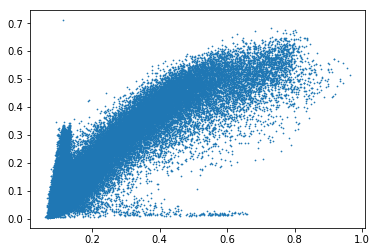

In [16]:
ax = plt.plot(image[:,:,0].ravel(),image[:,:,12].ravel(), linestyle='none', marker='o', markersize=0.7)

There are many different ways and methods and consequently packages, and sometimes I use pandas and seaborn.  

In [17]:
import pandas as pd
import seaborn as sns

In [18]:
data = pd.DataFrame(data=np.array([image[:,:,j].ravel() for j in range (0,13)]).transpose(), 
                     index=range(0,len(image[:,:,1].ravel())), 
                     columns = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])

Printing out a few lines of data to get a feeling for band values

In [19]:
data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12
0,0.1069,0.0739,0.0594,0.0523,0.0620,0.0852,0.0927,0.0897,0.1029,0.0719,0.0016,0.1187,0.0933
1,0.1106,0.0834,0.0716,0.0684,0.0890,0.1193,0.1344,0.1340,0.1500,0.0802,0.0017,0.1992,0.1575
2,0.1133,0.0974,0.0870,0.0847,0.1019,0.1358,0.1489,0.1547,0.1670,0.0865,0.0018,0.2032,0.1598
3,0.1156,0.0864,0.0746,0.0710,0.0895,0.1185,0.1322,0.1302,0.1476,0.0871,0.0018,0.1810,0.1392
4,0.3232,0.2530,0.2290,0.2349,0.2642,0.2948,0.3050,0.2930,0.3117,0.2054,0.0053,0.3058,0.2538


For fast visualization I often just grab a sample of the data, like in the case of drawing the kernel density plot to discern more structure (compared to scatterplot above) ...

In [20]:
sample = data.sample(n=200)

[(0, 0.2), (0, 0.2)]

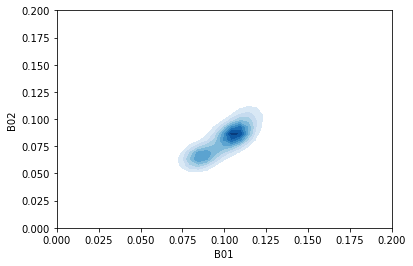

In [21]:
ax = sns.kdeplot(sample.B01, sample.B02, cmap="Blues", shade=True,  shade_lowest=False)
ax.set(ylim=(0, 0.2), xlim=(0,0.2))

... or drawing a scatter pair plot of the sample.

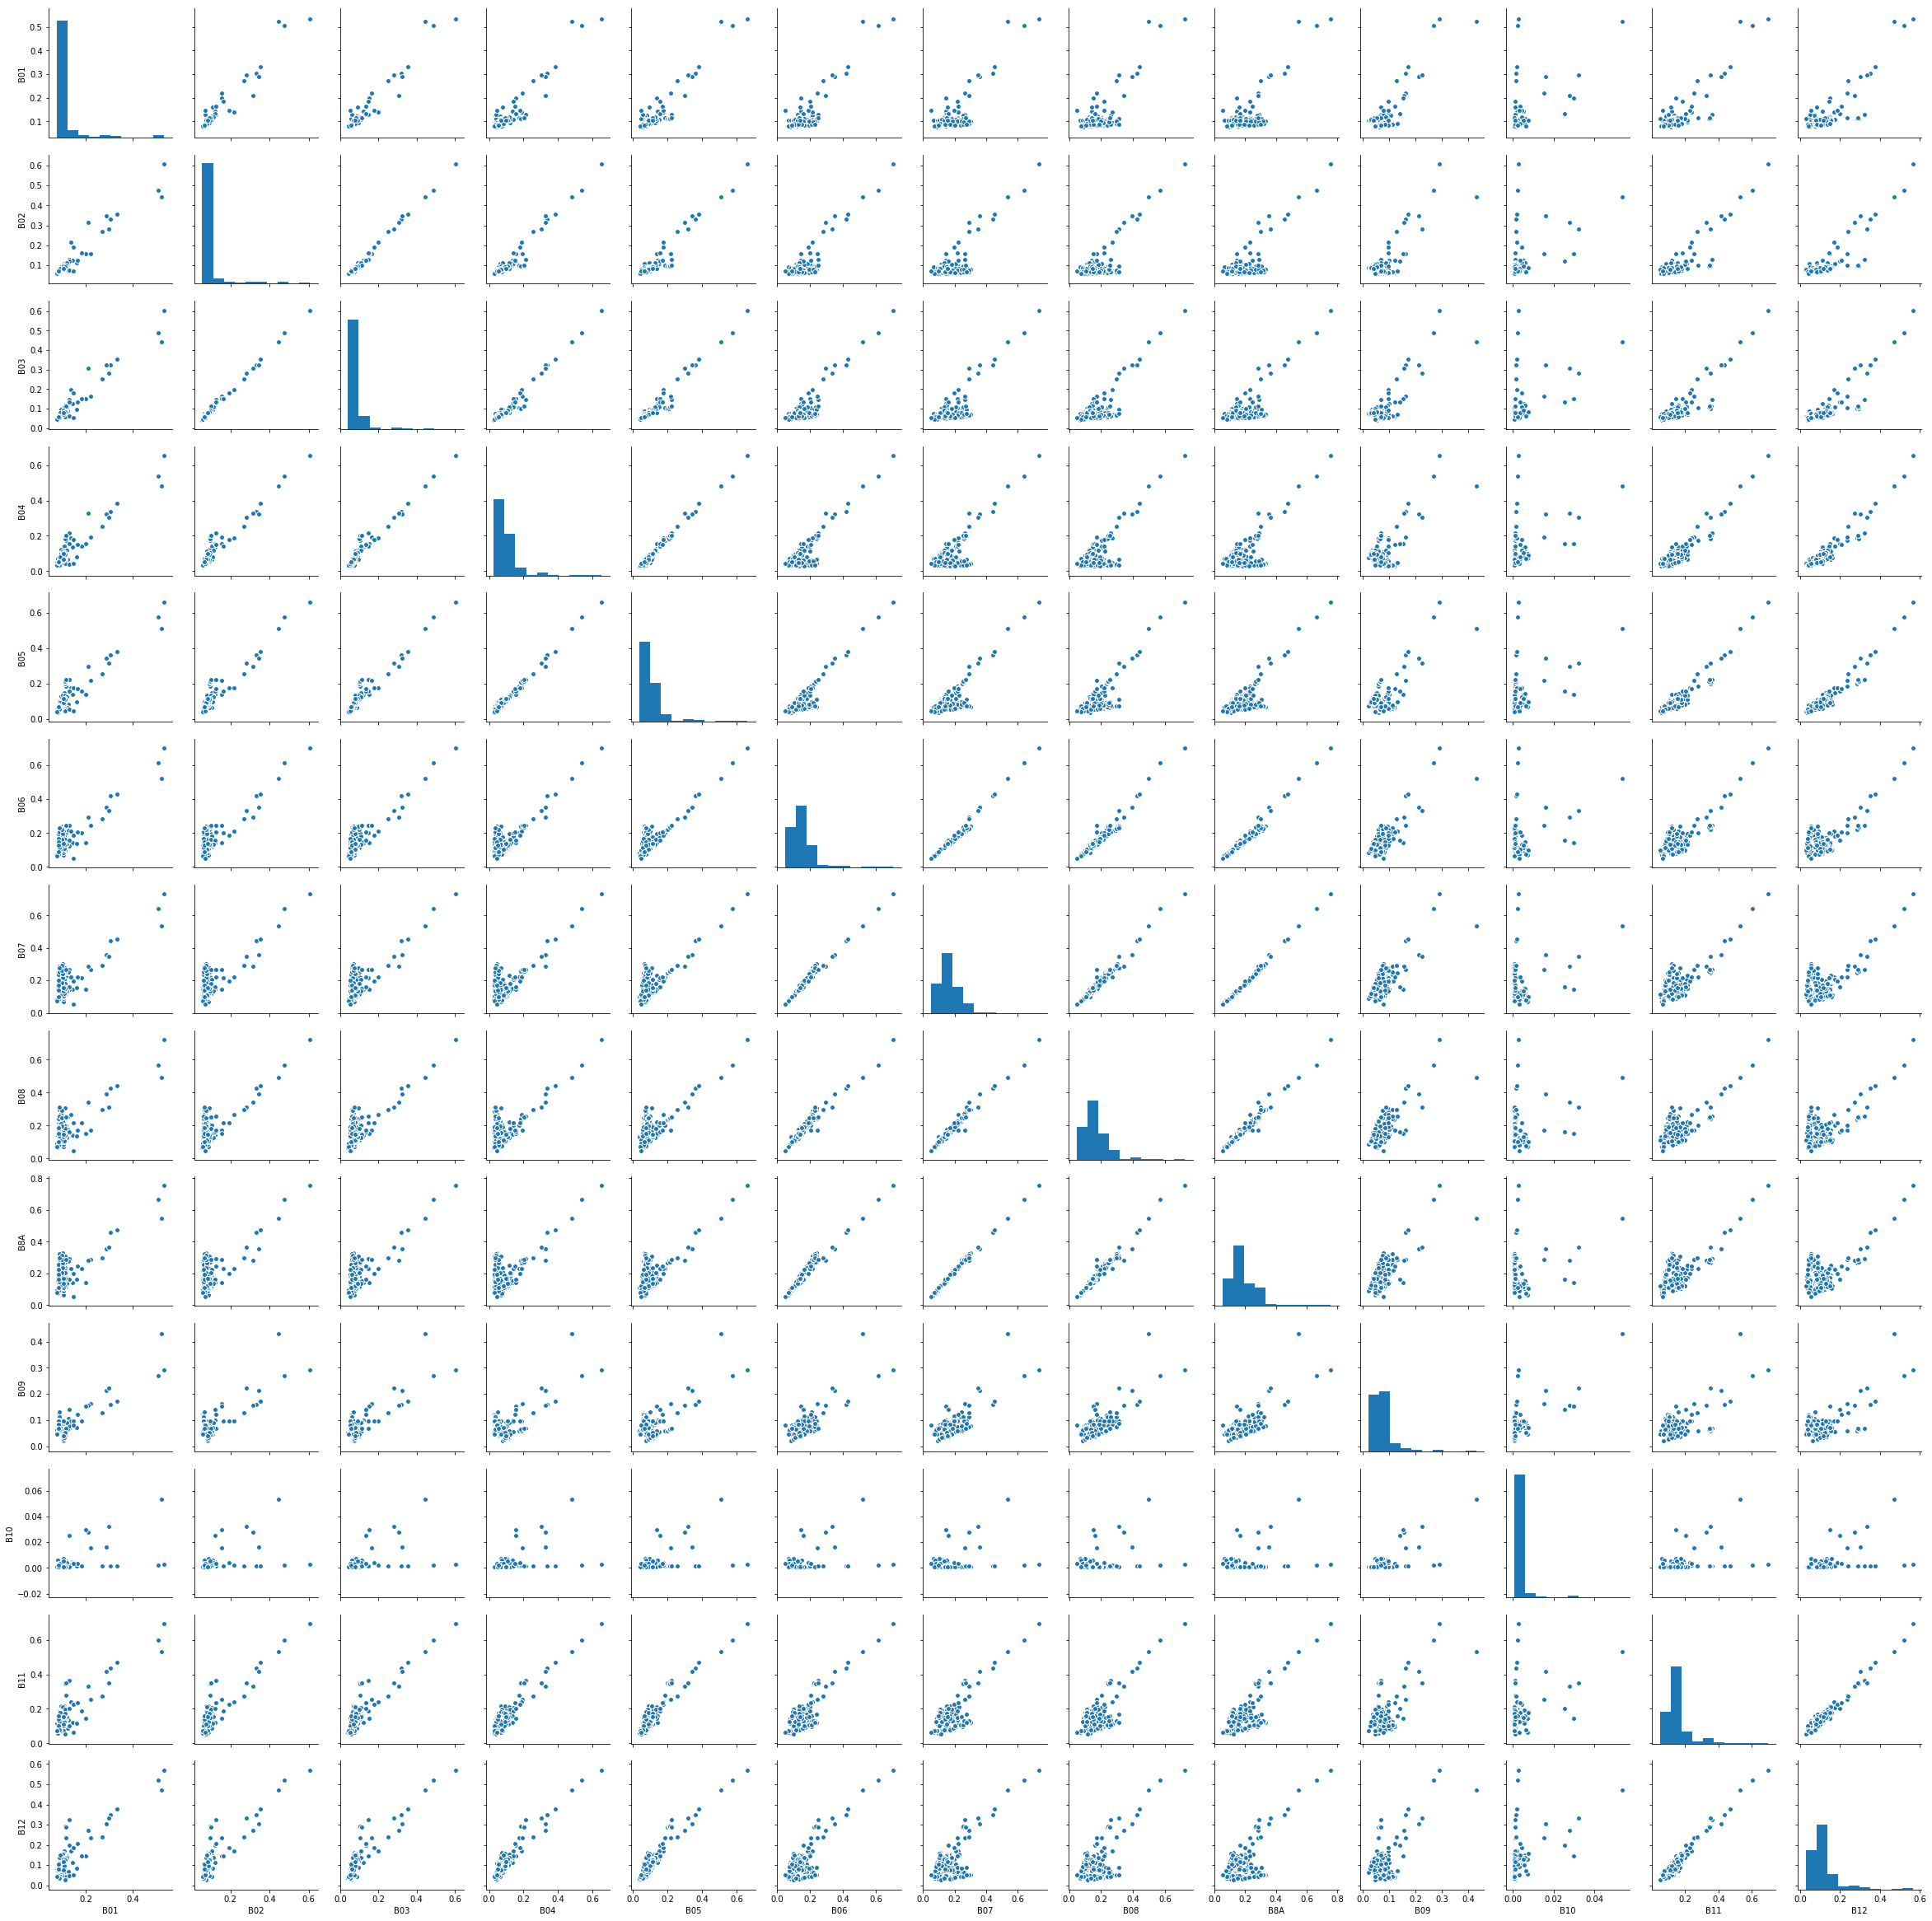

In [22]:
sns.pairplot(sample, kind="scatter")
plt.show()